In [48]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [39]:
@jax.jit
def balance(n_units, bins):
    # useful static values
    zero = jnp.zeros(1)
    index = jnp.arange(len(bins))

    # some info
    depth_diff = jnp.diff(bins)
    bin_bottom_level = jnp.concatenate([zero, jnp.cumsum(-depth_diff)])
    volume_for_bottom_bin = jnp.cumsum(jnp.concatenate([zero, -depth_diff]) * index)

    # distribute the water
    idx_of_last_filled_bin = jnp.searchsorted(volume_for_bottom_bin, n_units) - 1
    levels = bin_bottom_level[idx_of_last_filled_bin] - bin_bottom_level
    remainder = n_units - volume_for_bottom_bin[idx_of_last_filled_bin]
    levels = levels + (remainder / (idx_of_last_filled_bin + 1))
    levels = jnp.where(index <= idx_of_last_filled_bin, levels, 0)
    
    return levels

@jax.jit
def balance_arr(arr):
    n_units = arr[0]
    bins = jnp.max(arr[1:]) - arr[1:]
    return balance(n_units, bins)

v_balance = jax.vmap(balance_arr)

In [40]:
def get_neighbors(grid):
    grid = np.pad(grid, 1, mode="edge")
    neighbors = np.zeros(grid.shape + (3, 3))
    for i in [0, 1, 2]:
        for j in [0, 1, 2]:
            neighbors[:, :, i, j] = np.roll(grid, (1 - i, 1 - j), axis=(0, 1))
    return neighbors[1:-1, 1:-1, :, :]

def sum_neighbor_grid(neighbor_grid):
    pad_width = [(1, 1), (1, 1), (0, 0), (0, 0)]
    padded_vmd = np.pad(neighbor_grid, pad_width, constant_values=0)

    acc = np.zeros(padded_vmd.shape[:2])
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            offset = np.roll(padded_vmd, (i, j), (0, 1))[:, :, i + 1, j + 1]
            acc = offset + acc

    return acc[1:-1, 1:-1]

In [41]:
def flatten_sort(neighbor_grid):
    flat = neighbor_grid.reshape((-1, 9))
    sort_indices = np.argsort(flat, axis=1)
    sorted_flat = np.take_along_axis(flat, sort_indices, axis=1)
    return sorted_flat, sort_indices

def unflatten_unsort(sorted_flat, sort_indices):
    unsort_indeces = np.argsort(sort_indices, axis=-1)
    unsort = np.take_along_axis(sorted_flat, unsort_indeces, axis=1)
    n = int(sorted_flat.shape[0]**0.5)
    unflatten = unsort.reshape((n, n, 3, 3))
    return unflatten

In [43]:
def step(ground, water):
    neighbors = get_neighbors(ground + water)
    neighbors[:, :, 1, 1] = ground
    flat, sort_indices = flatten_sort(neighbors)
    water_flat = water.reshape((-1, 1))

    stacked = np.hstack([water_flat, flat])
    balanced = np.array(v_balance(stacked))
    unsorted_balanced = unflatten_unsort(balanced, sort_indices)

    return sum_neighbor_grid(unsorted_balanced)

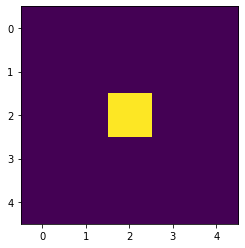

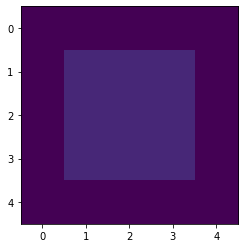

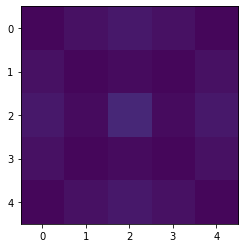

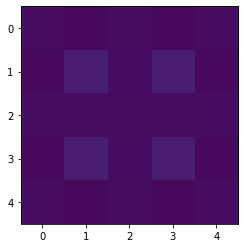

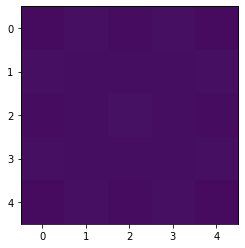

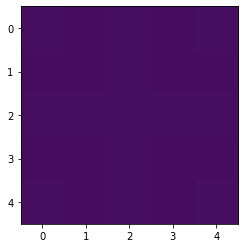

In [52]:
water = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
])

ground = np.zeros([5, 5])

plt.imshow(water, vmin=0, vmax=1)
plt.show()

for _ in range(5):
    water = step(ground, water)
    plt.imshow(water, vmin=0, vmax=1)
    plt.show()